# Pickle LRG files for Barry
This notebook includes code to ingest all the LRG files from FirstGen mocks for DESI KP4, including Abacus and EZmocks, cutsky and cubic. Barry has a strict set of data inputs, and everything gets pickled up into this format. This means the underlying clustering measurements etc., can be in any format.

Barry expects that you will read in/specify and pickle:
* The number of correlated datasets. **We set n_data == 1 below, but this would be 2 if we were providing i.e., NGC+SGC data vectors and wanted to consider different bias or polynomials for each cap**
* Pre and post-recon data power spectrum with 5 multipoles (some multipoles can be set to zero if they are not required/measured). **Pre- and Post-recon data currently set to None as there is no real data yet**
* N pre and post-recon mock power spectra with 5 multipoles (some can be set to zero if they are not required/measured).
* Pre and post-recon covariance matrices for the power spectra (some elements/blocks can be set to zero if they are not required/measured).
* A fiducial cosmology
* A window function convolution/binning matrix (some elements/blocks can be set to the identify matrix if they are not required/measured), corresponding k-binning and integral constraint. Only needed for power spectra.
* A compression matrix to convert the 3 even multipoles to 5 even+odd (can be given as a block identity matrix if you are not measuring odd multipoles). Only needed for power spectra.

Correlation functions are similar but a little simpler (only 3 multipoles, and no window function stuff).

The code below reads in all the files for both Abacus and EZmocks for LRGs. Hopefully it can be easily extended to do other tracers and redshift bins. As there is currently no real data, so we just parcel up all the mock measurements and covariance matrices. This is still enough to enable fits to the mock means, and individual realisations.

In [2]:
# Import the necessary packages, set up the fiducial cosmology and save the DESI template
import os
import pickle
import numpy as np
import scipy as sp
import pandas as pd
from astropy.io import ascii
import matplotlib.pyplot as plt
from scipy.interpolate import splrep, splev
from cosmoprimo import PowerSpectrumBAOFilter
from cosmoprimo.fiducial import DESI
from pypower import BaseMatrix, CatalogFFTPower, CatalogFFTCorr, PowerSpectrumMultipoles, PowerSpectrumSmoothWindow, PowerSpectrumSmoothWindowMatrix, PowerSpectrumOddWideAngleMatrix, setup_logging
from pycorr import TwoPointCorrelationFunction, project_to_multipoles

cosmo = DESI()

print(cosmo["Omega_b"]*cosmo["h"]**2, cosmo["Omega_cdm"]*cosmo["h"]**2, cosmo["Omega_m"]*cosmo["h"]**2 - cosmo["Omega_b"]*cosmo["h"]**2)
print(cosmo["ln10^10A_s"], cosmo["n_s"], cosmo["tau_reio"])
print(np.sum(cosmo["m_ncdm"]))

# Save the default DESI template to a file
k_min = 1e-4
k_max = 5
k_num = 2000
kl = np.logspace(np.log(k_min), np.log(k_max), k_num, base=np.e)
pkz = cosmo.get_fourier().pk_interpolator()
pk = pkz.to_1d(z=0)
pkv = pk(kl)
pknow = PowerSpectrumBAOFilter(pk, engine='wallish2018').smooth_pk_interpolator()
pksmv = pknow(kl)
np.savetxt("./DESI_Pk_template.dat", np.c_[kl, pksmv, pkv/pksmv - 1.0],  fmt="%g %g %g", header="k     pk_smooth     pk_ratio")

0.02237 0.12 0.1206441345126498
3.0363942552728806 0.9649 0.0544
0.05999991930682943


In [3]:
# A useful sort function for Christoph's files.
def sortfunc_cs(item):
    if "EZmock" in item:
        if "CubicBox" in item:
            return int(item.split("_")[1][4:-4])
        else:
            return int(item.split("_")[3][:-4])
    else:
        if "CubicBox" in item:
            return int(item.split("_")[3][:-4])
        else:
            return int(item.split("_")[1][-3:])

# A useful sort function for Sesh's files.
def sortfunc_sn(item):
    if "EZmock" in item:
        if "CubicBox" in item:
            return int(item.split("_")[1][4:-4])
        else:
            return int(item.split("_")[3][:-4])
    else:
        if "CubicBox" in item:
            return int(item.split("_")[3][2:5])
        else:
            return int(item.split("_")[4][2:5])
        
# A useful sort function for Daniel's files.
def sortfunc_dfs(item):
    if "EZmock" in item:
        if "CubicBox" in item:
            return int(item.split("_")[4][4:-4])
        else:
            return int(item.split("_")[3][:-4])
    else:
        if "CubicBox" in item:
            return int(item.split("_")[3][2:5])
        else:
            return int(item.split("_")[4][2:5])
        
# A useful sort function for Boryana's files.
def sortfunc_bh(item):
    if "EZmock" in item:
        if "CubicBox" in item:
            return int(item.split("_")[4][4:-4])
        else:
            return int(item.split("_")[3][:-4])
    else:
        if "CubicBox" in item:
            return int(item.split("_")[3][2:5])
        else:
            return int(item.split("_")[4][2:5])

# Power spectrum routines

In [21]:
# Useful utility function to collate some Pk data
def collect_pk_data(pre_files, post_files, pre_cov_files, post_cov_files, winfile, zeff, prezname, postzname, name, preformat="jmf", postformat="jmf", precovformat="jmf", postcovformat="jmf"):
    
    ks = None
    pre_cov, post_cov = None, None
    pre_data, post_data = None, None
    pre_mocks, post_mocks = None, None
    if pre_files is not None:
        if preformat=="jmf": 
            pre_res = getpk(pre_files, prezname) 
        elif preformat == "bh":
            pre_res = getpk_bh(pre_files, prezname)
        elif preformat == "cgq":
            pre_res = getpk_cgq(pre_files, prezname)
        elif preformat == "dfs":
            pre_res = getpk_dfs(pre_files, prezname)
        else:
            pre_res = getpk_sn(pre_files, prezname)
        ks = pre_res[0]["k"].to_numpy()
        pre_cov = format_pk_cov(len(ks), pre_cov_file) if precovformat=="jmf" else format_pk_analytic(len(ks), pre_cov_file)
        pre_mocks = [v for v in pre_res]
    if post_files is not None:
        if postformat=="jmf": 
            post_res = getpk(post_files, postzname, ks=ks)
        elif postformat == "bh":
            post_res = getpk_bh(post_files, postzname, ks=ks)
        elif postformat == "cgq":
            post_res = getpk_cgq(post_files, postzname, ks=ks)
        elif postformat == "dfs":
            post_res = getpk_dfs(post_files, postzname, ks=ks)
        else:
            post_res = getpk_sn(post_files, postzname, ks=ks)
        ks = post_res[0]["k"].to_numpy()
        post_cov = format_pk_cov(len(ks), post_cov_file, postcovformat, zname=postzname) if postcovformat=="jmf" or postcovformat=="dfs" else format_pk_analytic(len(ks), pre_cov_file)
        post_mocks = [v for v in post_res]
                
    if winfile is not None:
        winmat, wideangle = getwin(ks, winfile)
    else:
        winmat, wideangle = getwin_dummy(ks)
                
    split = {
        "n_data": 1,
        "pre-recon data": pre_data,
        "pre-recon cov": pre_cov,
        "post-recon data": post_data,
        "post-recon cov": post_cov,
        "pre-recon mocks": pre_mocks,
        "post-recon mocks": post_mocks,
        "cosmology": {
            "om": cosmo["Omega_m"],
            "h0": cosmo["h"],
            "z": zeff,
            "ob": cosmo["Omega_b"],
            "ns": cosmo["n_s"],
            "mnu": np.sum(cosmo["m_ncdm"]),
            "reconsmoothscale": 10,
        },
        "name": name,
        "winfit": winmat,
        "winpk": None,  # We can set this to None; Barry will set it to zeroes given the length of the data vector.
        "m_mat": wideangle,
    }
    
    with open(f"./" + name.lower().replace(" ", "_")+".pkl", "wb") as f:
        pickle.dump(split, f)
        
    return split

# Power Spectrum. Juan Mena Fernández style where everything is put into single files per multipole. Barry needs 5 even+odd multipoles, but the odd ones can be filled with zeros if these haven't been measured, as is done here.
def getpk(loc, zname, ks=None):
    
    kin = pd.read_csv(loc+"/k.txt", comment="#", skiprows=0, delim_whitespace=True, header=None).to_numpy().T[0]
    pkmat = [pd.read_csv(loc+f"/Pk_{ell}"+zname+".txt", comment="#", skiprows=0, delim_whitespace=True, header=None).to_numpy().T for ell in [0,2,4]]

    # Overwrite the <k> with the bin centres as we now use a binning matrix to correct to <P(k)>
    kin = np.linspace(0.0, 0.5, 100, endpoint=False) + 0.0025
    
    res = []
    nmocks = np.shape(pkmat[0])[0]
    for i in range(nmocks):
        df = {}
        df["k"] = kin
        for l, ell in enumerate([0, 2, 4]):
            df[f"pk{ell}"] = pkmat[l][i]
        df["pk1"] = np.zeros(len(df["k"]))
        df["pk3"] = np.zeros(len(df["k"]))
        res.append(pd.DataFrame(df)[["k", "pk0", "pk1", "pk2", "pk3", "pk4"]])
        
    return res

# Power Spectrum, Sesh Nadathur style where we read in the .npy files. Barry needs 5 even+odd multipoles, but the odd ones can be filled with zeros if these haven't been measured, as is done here.
# Forces the k-values to be the same between pre- and post-recon if they are available as this is needed to align the window function.
def getpk_sn(loc, zname, ks=None):

    rebinfactor = 1
    
    files = [loc + f for f in os.listdir(loc) if zname in f and ".npy" in f]
    if "CubicBox" in files[0] and "LRG" in files[0]:
         files = [f for f in files if "b2.35" in f]
    files.sort(key=sortfunc_sn)
                
    # Overwrite the <k> with the bin centres as we now use a binning matrix to correct to <P(k)>
    ks = np.linspace(0.0, 0.5, 100, endpoint=False) + 0.0025
    
    res = []
    for f in files:
        data = PowerSpectrumMultipoles.load(f)
        data.slice(slice(0,100,1))
        data.rebin(rebinfactor)
        df = pd.DataFrame(np.vstack(data(ell=[0,2,4], return_k=True)).T.real, columns=["k", "pk0", "pk2", "pk4"])
        df["pk1"] = np.zeros(len(df["k"]))
        df["pk3"] = np.zeros(len(df["k"]))
        df["nk"] = data.nmodes
        if ks is not None:
            df["k"] = ks
        res.append(df[["k", "pk0", "pk1", "pk2", "pk3", "pk4"]])
    return res

# Power Spectrum, Daniel Forero-Sanchez style where each power spectrum file is in it's own directory. Barry needs 5 even+odd multipoles, but the odd ones can be filled with zeros if these haven't been measured, as is done here.
# Forces the k-values to be the same between pre- and post-recon if they are available as this is needed to align the window function.
def getpk_dfs(loc, zname, ks=None):

    rebinfactor = 1
    
    files = [loc + f + "/sym_pk.pkl.npy" for f in os.listdir(loc)]
    files.sort(key=sortfunc_dfs)

    # Overwrite the <k> with the bin centres as we now use a binning matrix to correct to <P(k)>
    kin = np.linspace(0.0, 0.5, 100, endpoint=False) + 0.0025
                
    res = []
    for f in files:
        data = CatalogFFTPower.load(f).poles
        data.slice(slice(0,100,1))
        data.rebin(rebinfactor)
        df = pd.DataFrame(np.vstack(data(ell=[0,2,4], return_k=True)).T.real, columns=["k", "pk0", "pk2", "pk4"])
        df["pk1"] = np.zeros(len(df["k"]))
        df["pk3"] = np.zeros(len(df["k"]))
        df["nk"] = data.nmodes
        if ks is not None:
            df["k"] = ks
        res.append(df[["k", "pk0", "pk1", "pk2", "pk3", "pk4"]])
    return res
    
# Power Spectrum, Boryana Hadzhiyska style where each power spectrum file is a csv to be read in using astropy and both pre- and post-recon are in the directory. Barry needs 5 even+odd multipoles, but the odd ones can be filled with zeros if these haven't been measured, as is done here.
# Forces the k-values to be the same between pre- and post-recon if they are available as this is needed to align the window function.
def getpk_bh(loc, zname, ks=None):
    
    files = [loc + f for f in os.listdir(loc) if 'reciso' not in f and 'velbias' not in f and 'hod' not in f]
    files.sort(key=sortfunc_bh)

    # Overwrite the <k> with the bin centres as we now use a binning matrix to correct to <P(k)>
    kin = np.linspace(0.0, 0.5, 100, endpoint=False) + 0.0025
    
    res = []
    for f in files:
        data = ascii.read(f)
        df = pd.DataFrame(data['kmid'])
        df["k"] = df["kmid"]
        df["pk0"] = data["P0(k)_CV"]
        df["pk1"] = np.zeros(len(df["k"]))
        df["pk2"] = data["P2(k)_CV"]
        df["pk3"] = np.zeros(len(df["k"]))
        df["pk4"] = data["P4(k)_CV"]
        df["nk"] = data["nmodes"]
        df = df.drop(df[df["k"] >= 0.5].index)
        if ks is not None:
            df["k"] = ks
        res.append(df[["k", "pk0", "pk1", "pk2", "pk3", "pk4"]])
    return res

    
# Window function matrix. The window functions are stored in a dictionary of 'step sizes' i.e., how many bins get stuck together relative to the 
# pk measurements so that we can rebin the P(k) at run time if required. Each step size is a dictionary with:
#    the input and output k binning (w_ks_input, w_ks_output), the window function matrix (w_transform) and integral constraint (w_k0_scale).
# The window function assumes 6 input and 5 output multipoles. For cubic sims, we can set the integral constraint to zero and window matrix to a binning matrix, as is done here.
def getwin_dummy(ks):
    
    dk = ks[1] - ks[0]
    ks_input = np.logspace(-3.0, np.log10(0.5), 500)

    binmat = np.zeros((len(ks), len(ks_input)))
    for ii in range(len(ks_input)):

        # Define basis vector
        pkvec = np.zeros_like(ks_input)
        pkvec[ii] = 1

        # Define the spline:
        pkvec_spline = splrep(ks_input, pkvec)

        # Now compute binned basis vector:
        tmp = np.zeros_like(ks)
        for i, kk in enumerate(ks):
            kl = kk - dk / 2
            kr = kk + dk / 2
            kin = np.linspace(kl, kr, 100)
            tmp[i] = np.trapz(kin**2 * splev(kin, pkvec_spline, ext=3), x=kin) * 3 / (kr**3 - kl**3)

        binmat[:, ii] = tmp

    w_transform = np.zeros((5 * ks.size, 6 * ks_input.size))
    for i in range(5):
        w_transform[i*ks.size: (i+1)*ks.size , i*ks_input.size : (i+1)*ks_input.size] = binmat
    
    # The conversion matrix M from Beutler 2019. Used to compute the odd multipole models given the even multipoles. In the absence of wide angle effects, or if we don't care about
    # the odd multipoles, we can set this to a block matrix with identity matrices in the appropriate places, as is done here.
    matrix = np.zeros((6 * ks_input.size, 3 * ks_input.size))
    matrix[: ks_input.size, : ks_input.size] = np.diag(np.ones(ks_input.size))
    matrix[2 * ks_input.size : 3 * ks_input.size, ks_input.size : 2 * ks_input.size] = np.diag(np.ones(ks_input.size))
    matrix[4 * ks_input.size : 5 * ks_input.size, 2 * ks_input.size :] = np.diag(np.ones(ks_input.size))
    
    res = {"w_ks_input": ks_input, "w_k0_scale": np.zeros(ks.size), "w_transform": w_transform, "w_ks_output": ks}
    return {1: res}, matrix  # Step size is one


# Read's in Juan's k-space window multipoles and use the routines in pypower to convert these to window and wideangle matrices
def getwin(ks, winfile):
    
    wa_orders = 1 # wide-angle order
    ellsin = [0, 2, 4] # input (theory) multipoles
    ellsout = [0, 1, 2, 3, 4] # output multipoles
    
    # Check for the presence of window and wide angle matrix files already. If we find both, just load them in
    winmatname = winfile + "_matrix.npy"
    wideanglename = winfile + "_wideangle.npy"
    if os.path.exists(winmatname) and os.path.exists(wideanglename):
    
        wm = BaseMatrix.load(winmatname)
        wam = BaseMatrix.load(wideanglename)
        
    else:

        window = PowerSpectrumSmoothWindow.load(winfile + ".npy")

        sep = np.geomspace(1e-4, 1e4, 1024*16) # configuration space separation for FFTlog
        kin_rebin = 8 # rebin input theory to save memory, and run time when fitting.
        kin_lim = (1e-4, 0.4) # pre-cut input (theory) ks to save some memory
        projsin = ellsin + PowerSpectrumOddWideAngleMatrix.propose_out(ellsin, wa_orders=wa_orders)
        wm = PowerSpectrumSmoothWindowMatrix(ks, projsin=projsin, projsout=ellsout, window=window, sep=sep, kin_rebin=kin_rebin, kin_lim=kin_lim, default_zero=True)
        wam = PowerSpectrumOddWideAngleMatrix(wm.xin[0], projsin=ellsin, projsout=wm.projsin, d=1., wa_orders=wa_orders, los=window.attrs['los_type'])
        
        # Save the matrices
        wm.save(winmatname)
        wam.save(wideanglename)
    
    # The pypower functions store the inner chunks in the order 0, 2, 4, 1, 3, 5, 
    # but Barry expects 0, 1, 2, 3, 4, 5. So let's break the matrices apart and reorder them.
    wm_reshape = np.vsplit(wm.value, 6)
    wm_reshape = np.concatenate([wm_reshape[0],wm_reshape[3],wm_reshape[1],wm_reshape[4],wm_reshape[2],wm_reshape[5]]).T    
    wam_reshape = np.hsplit(wam.value, 6)
    wam_reshape = np.concatenate([wam_reshape[0],wam_reshape[3],wam_reshape[1],wam_reshape[4],wam_reshape[2],wam_reshape[5]], axis=1).T
    
    res = {"w_ks_input": wm.xin[0], "w_k0_scale": np.zeros(ks.size), "w_transform": wm_reshape, "w_ks_output": wm.xout[0]}
    winmat = {1: res}   # Step size is one, but we could modify this to contain other stepsizes too.
    
    return winmat, wam_reshape

# Power spectrum covariance matrix. Needs to have 6 multipoles, but if the some of them haven't been measured, we can set the covariance matrix elements to the identity matrix, as is done here.
def format_pk_cov(nks, covfile, covformat="jmf", zname=None):

    if covformat == "jmf":
        cov_input = pd.read_csv(covfile, comment="#", delim_whitespace=True, header=None).to_numpy()        
        nin = nks
        cov = np.eye(5 * nks)
        cov[:nks, :nks] = cov_input[:nks, :nks]
        cov[:nks, 2 * nks : 3 * nks] = cov_input[:nks, nin : nin + nks]
        cov[:nks, 4 * nks : 5 * nks] = cov_input[:nks, 2 * nin : 2 * nin + nks]
        cov[2 * nks : 3 * nks, :nks] = cov_input[nin : nin + nks, :nks]
        cov[2 * nks : 3 * nks, 2 * nks : 3 * nks] = cov_input[nin : nin + nks, nin : nin + nks]
        cov[2 * nks : 3 * nks, 4 * nks : 5 * nks] = cov_input[nin : nin + nks, 2 * nin : 2 * nin + nks]
        cov[4 * nks : 5 * nks, :nks] = cov_input[2 * nin : 2 * nin + nks, :nks]
        cov[4 * nks : 5 * nks, 2 * nks : 3 * nks] = cov_input[2 * nin : 2 * nin + nks, nin : nin + nks]
        cov[4 * nks : 5 * nks, 4 * nks : 5 * nks] = cov_input[2 * nin : 2 * nin + nks, 2 * nin : 2 * nin + nks]
    else:
        pks = getpk_dfs(covfile, zname)
        cov = np.cov(np.array([np.concatenate([df["pk0"], df["pk1"], df["pk2"], df["pk3"], df["pk4"]]) for df in pks]).T)
        cov[nks:2*nks, nks:2*nks] = np.eye(nks)
        cov[3*nks:4*nks, 3*nks:4*nks] = np.eye(nks)
            
    # Check the covariance matrix is invertible
    v = np.diag(cov @ np.linalg.inv(cov))
    if not np.all(np.isclose(v, 1)):
        print("ERROR, setting an inappropriate covariance matrix that is almost singular!!!!")
        #print(f"These should all be 1: {v}")
    
    return cov

# Plot the power spectra, for sanity checking
def plot_pk(split, pre=True, post=True):
    
    if pre:
        color = ["r", "b", "g"]
        ks = split["pre-recon mocks"][0]["k"]
        nmocks = len(split["pre-recon mocks"])
        label = [r"$P_{0}(k)$", r"$P_{2}(k)$", r"$P_{4}(k)$"]
        for m, pk in enumerate(["pk0", "pk2", "pk4"]):
            yerr = ks * np.sqrt(np.diag(split["pre-recon cov"]))[2 * m * len(ks) : (2 * m + 1) * len(ks)]
            plt.errorbar(
                ks,
                ks * np.mean([split["pre-recon mocks"][i][pk] for i in range(nmocks)], axis=0),
                yerr=yerr,
                marker="o",
                ls="None",
                c=color[m],
                label=label[m],
            )
            for i in range(nmocks):
                plt.errorbar(ks, ks * split["pre-recon mocks"][i][pk], marker="None", ls="-", c='k', alpha=1.0 / nmocks**(3.0/4.0))
        plt.xlabel(r"$k$")
        plt.ylabel(r"$k\,P(k)$")
        plt.title(split["name"] + " Prerecon")
        plt.legend(loc='upper right')
        plt.show()
    
    if post:
        color = ["r", "b", "g"]
        ks = split["post-recon mocks"][0]["k"]
        nmocks = len(split["post-recon mocks"])
        label = [r"$P_{0}(k)$", r"$P_{2}(k)$", r"$P_{4}(k)$"]
        for m, pk in enumerate(["pk0", "pk2", "pk4"]):
            yerr = ks * np.sqrt(np.diag(split["post-recon cov"]))[2 * m * len(ks) : (2 * m + 1) * len(ks)]
            plt.errorbar(
                ks,
                ks * np.mean([split["post-recon mocks"][i][pk] for i in range(nmocks)], axis=0),
                yerr=yerr,
                marker="o",
                ls="None",
                c=color[m],
                label=label[m],
            )
            for i in range(nmocks):
                plt.errorbar(ks, ks * split["post-recon mocks"][i][pk], marker="None", ls="-", c='k', alpha=1.0 / nmocks**(3.0/4.0))
        plt.xlabel(r"$k$")
        plt.ylabel(r"$k\,P(k)$")
        plt.title(split["name"] + " Postrecon")
        plt.legend(loc='upper right')
        plt.show()

# Correlation function routines

In [25]:
# Useful utility function to collate some Xi data
def collect_xi_data(pre_files, post_files, pre_cov_file, post_cov_file, zeff, prezname, postzname, name, preformat="jmf", postformat="jmf", precovformat="jmf", postcovformat="jmf"):

    pre_cov, post_cov = None, None
    pre_data, post_data = None, None
    pre_mocks, post_mocks = None, None
    if pre_files is not None:
        if preformat=="jmf":
            pre_res = getxi(pre_files, prezname)
        elif preformat=="dfs":
            pre_res = getxi_dfs(post_files, prezname)
        else:
            pre_res = getxi_cs(pre_files, prezname)
        ss = pre_res[0]["s"].to_numpy()
        pre_cov = format_xi_cov(len(ss), pre_cov_file)
        pre_mocks = [v for v in pre_res]
    if post_files is not None:
        if postformat=="jmf":
            post_res = getxi(post_files, postzname)
        elif postformat=="dfs":
            post_res = getxi_dfs(post_files, postzname)
        else:
            post_res = getxi_cs(post_files, postzname)
        ss = post_res[0]["s"].to_numpy()
        post_cov = format_xi_cov(len(ss), post_cov_file, covformat=postcovformat)
        post_mocks = [v for v in post_res]   
    
    split = {
        "n_data": 1,
        "pre-recon data": pre_data,
        "pre-recon cov": pre_cov,
        "post-recon data": post_data,
        "post-recon cov": post_cov,
        "pre-recon mocks": pre_mocks,
        "post-recon mocks": post_mocks,
        "cosmology": {
            "om": cosmo["Omega_m"],
            "h0": cosmo["h"],
            "z": zeff,
            "ob": cosmo["Omega_b"],
            "ns": cosmo["n_s"],
            "mnu": np.sum(cosmo["m_ncdm"]),
            "reconsmoothscale": 15,
        },
        "name": name,
    }
    
    with open(f"./" + name.lower().replace(" ", "_")+".pkl", "wb") as f:
        pickle.dump(split, f)
        
    return split

# Correlation function. Juan Mena Fernández style where everything is put into single files per multipole
def getxi(loc, zname):
    sin = pd.read_csv(loc+"/s.txt", comment="#", skiprows=0, delim_whitespace=True, header=None).to_numpy().T[0]
    ximat = [pd.read_csv(loc+f"/Xi_{ell}"+zname+".txt", comment="#", skiprows=0, delim_whitespace=True, header=None).to_numpy().T for ell in [0,2,4]]
        
    res = []
    nmocks = np.shape(ximat[0])[0]
    for i in range(nmocks):
        df = {}
        df["s"] = sin
        for l, ell in enumerate([0, 2, 4]):
            df[f"xi{ell}"] = ximat[l][i]
        res.append(pd.DataFrame(df))
    
    return res

# Correlation function. Christoph Saulder style, where we read in the .npy files and rebin with 4Mpc/h binning
def getxi_cs(loc, zname):
    
    rebinfactor = 4
    
    files = [loc + f for f in os.listdir(loc) if zname in f and ".npy" in f and "poles" not in f]
    files.sort(key=sortfunc_cs)
        
    res = []
    for f in files:
        data = TwoPointCorrelationFunction.load(f)
        data.rebin((rebinfactor, 1))
        df = pd.DataFrame(np.vstack(project_to_multipoles(data)).T, columns=["s", "xi0", "xi2", "xi4"])
        res.append(df)
    return res

# Correlation function. Daniel Forero-Sanchez style, where we read in the .npy files and rebin with 4Mpc/h binning
def getxi_dfs(loc, zname):
    
    rebinfactor = 4
    
    files = [loc + f + "/sym_fft_tpcf.pkl.npy" for f in os.listdir(loc)]
    files.sort(key=sortfunc_dfs)
        
    res = []
    for f in files:
        data = CatalogFFTCorr.load(f).poles
        data.rebin(rebinfactor)
        df = pd.DataFrame(np.vstack(data(ell=[0,2,4], return_s=True)).T.real, columns=["s", "xi0", "xi2", "xi4"])
        res.append(df)
    return res

# Correlation function covariance matrix.
def format_xi_cov(nss, covfile, covformat="jmf", zname=None):

    if covformat == "jmf" or covformat == "cs":
        cov_input = pd.read_csv(covfile, comment="#", delim_whitespace=True, header=None).to_numpy()
        nin = nss
        cov = np.zeros((3 * nss, 3 * nss))
        cov[:nss, :nss] = cov_input[:nss, :nss]
        cov[:nss, nss : 2 * nss] = cov_input[:nss, nin : nin + nss]
        cov[:nss, 2 * nss :] = cov_input[:nss, 2 * nin : 2 * nin + nss]
        cov[nss : 2 * nss, :nss] = cov_input[nin : nin + nss, :nss]
        cov[nss : 2 * nss, nss : 2 * nss] = cov_input[nin : nin + nss, nin : nin + nss]
        cov[nss : 2 * nss, 2 * nss :] = cov_input[nin : nin + nss, 2 * nin : 2 * nin + nss]
        cov[2 * nss :, :nss] = cov_input[2 * nin : 2 * nin + nss, :nss]
        cov[2 * nss :, nss : 2 * nss] = cov_input[2 * nin : 2 * nin + nss, nin : nin + nss]
        cov[2 * nss :, 2 * nss :] = cov_input[2 * nin : 2 * nin + nss, 2 * nin : 2 * nin + nss]
    else:
        xis = getxi_dfs(covfile, zname)
        cov = np.cov(np.array([np.concatenate([df["xi0"], df["xi2"], df["xi4"]]) for df in xis]).T)
    
    #plt.imshow(cov/np.sqrt(np.outer(np.diag(cov), np.diag(cov))))
    #plt.show()
    
    # Check the covariance matrix is invertible
    v = np.diag(cov @ np.linalg.inv(cov))
    if not np.all(np.isclose(v, 1)):
        print("ERROR, setting an inappropriate covariance matrix that is almost singular!!!!")
        #print(f"These should all be 1: {v}")

    return cov
    
# Plot the correlation function, for sanity checking
def plot_xi(split, pre=True, post=True):
    
    if pre:
    
        color = ["r", "b", "g"]
        ss = split["pre-recon mocks"][0]["s"]
        nmocks = len(split["pre-recon mocks"])
        label = [r"$\xi_{0}(k)$", r"$\xi_{2}(k)$", r"$\xi_{4}(k)$"]
        for m, xi in enumerate(["xi0", "xi2", "xi4"]):
            yerr = ss ** 2 * np.sqrt(np.diag(split["pre-recon cov"]))[m * len(ss) : (m + 1) * len(ss)]
            plt.errorbar(
                ss,
                ss ** 2 * np.mean([split["pre-recon mocks"][i][xi] for i in range(nmocks)], axis=0),
                yerr=yerr,
                marker="o",
                ls="None",
                c=color[m],
                label=label[m],
            )
            for i in range(nmocks):
                plt.errorbar(ss, ss ** 2 * split["pre-recon mocks"][i][xi], marker="None", ls="-", c='k', alpha=1.0 / nmocks**(3.0/4.0))
        plt.xlabel(r"$s$")
        plt.ylabel(r"$s^{2}\,\xi(s)$")
        plt.title(split["name"] + " Prerecon")
        plt.legend(loc='upper right')
        plt.show()
        
    if post:
        
        color = ["r", "b", "g"]
        ss = split["post-recon mocks"][0]["s"]
        nmocks = len(split["post-recon mocks"])
        label = [r"$\xi_{0}(k)$", r"$\xi_{2}(k)$", r"$\xi_{4}(k)$"]
        for m, xi in enumerate(["xi0", "xi2", "xi4"]):
            yerr = ss ** 2 * np.sqrt(np.diag(split["pre-recon cov"]))[m * len(ss) : (m + 1) * len(ss)]
            plt.errorbar(
                ss,
                ss ** 2 * np.mean([split["post-recon mocks"][i][xi] for i in range(nmocks)], axis=0),
                yerr=yerr,
                marker="o",
                ls="None",
                c=color[m],
                label=label[m],
            )
            for i in range(nmocks):
                plt.errorbar(ss, ss ** 2 * split["post-recon mocks"][i][xi], marker="None", ls="-", c='k', alpha=1.0 / nmocks**(3.0/4.0))
        plt.xlabel(r"$s$")
        plt.ylabel(r"$s^{2}\,\xi(s)$")
        plt.title(split["name"] + " Postrecon")
        plt.legend(loc='upper right')
        plt.show()

# Abacus Cubic Mocks

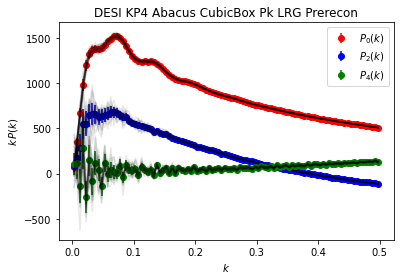

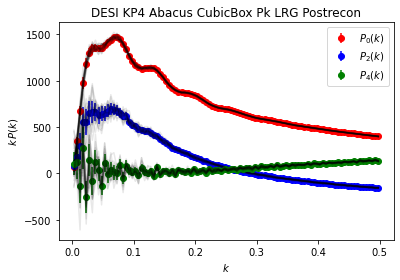

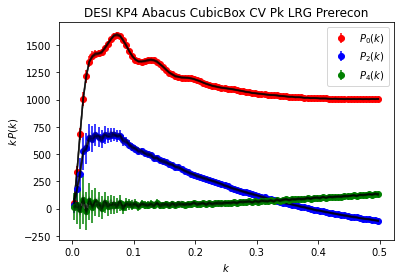

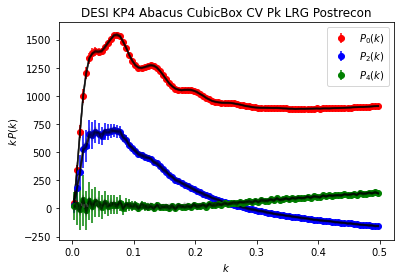

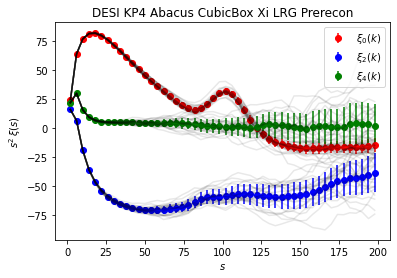

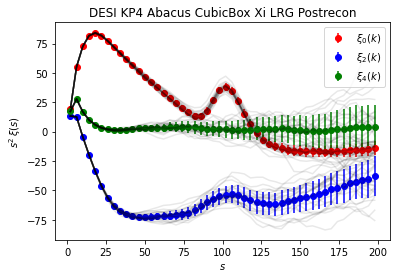

In [6]:
# General file paths
path_abacus = "/global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/AbacusSummit/CubicBox/LRG/"
path_ezmock = "/global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/EZmock/CubicBox/LRG/"

# Cubic box redshift
z = 0.8  

# Power Spectrum
pre_file = path_abacus + "/Pk/Pre/jmena/nmesh_512/dk0.005/"                        # 25 Abacus sims          
post_file = path_abacus + "/Pk/Post/nadathur/fiducial_settings/dk0.005/"           # 25 postrecon Abacus sims
pre_cov_file = path_ezmock + "/Pk/jmena/nmesh_512/dk0.005/cov.txt"                 # Prerecon EZmock covariance
post_cov_file = path_ezmock + "/Pk/Post/forero/fiducial_settings/dk0.005/z0.800/"  # Postrecon EZmock covariance
name = f"DESI KP4 Abacus CubicBox Pk LRG"
data = collect_pk_data(pre_file, post_file, pre_cov_file, post_cov_file, None, z, "", "", name, preformat="jmf", postformat="sn", precovformat="jmf", postcovformat="dfs")
plot_pk(data) # Plot the data to check things

# Power Spectrum Control Variate  
pre_file = path_abacus + "/Pk_CV/Pre/boryanah/"                                    # 25 Abacus sims as CV
post_file = path_abacus + "/Pk_CV/Post/boryanah/"                                  # 25 postrecon Abacus sims as CV
pre_cov_file = path_ezmock + "/Pk/jmena/nmesh_512/dk0.005/cov.txt"                 # Uses the normal (not CV) EZmock covariance
post_cov_file = path_ezmock + "/Pk/Post/forero/fiducial_settings/dk0.005/z0.800/"  # Uses the normal (not CV) Postrecon EZmock covariance
name = f"DESI KP4 Abacus CubicBox CV Pk LRG"
data = collect_pk_data(pre_file, post_file, pre_cov_file, post_cov_file, None, z, "", "", name, preformat="bh", postformat="bh", precovformat="jmf", postcovformat="dfs")
plot_pk(data) # Plot the data to check things

# Correlation Function
pre_file = path_abacus + "/Xi/Pre/jmena/"                                  # 25 Abacus sims  
post_file = path_abacus + "/Xi/Post/jmena/"                                # 25 postrecon Abacus sims
pre_cov_file = path_ezmock + "/Xi/jmena/cov.txt"                           # Prerecon EZmock covariance
post_cov_file = path_ezmock + "/Xi/Post/forero/fiducial_settings/z0.800/"  # Postrecon EZmock covariance
name = f"DESI KP4 Abacus CubicBox Xi LRG"
data = collect_xi_data(pre_file, post_file, pre_cov_file, post_cov_file, z, "", "", name, preformat="jmf", postformat="jmf", precovformat="jmf", postcovformat="dfs")
plot_xi(data) # Plot the data to check things"""

# EZmocks Cubic Mocks

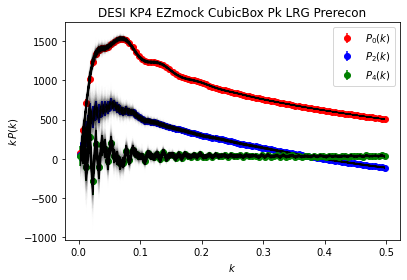

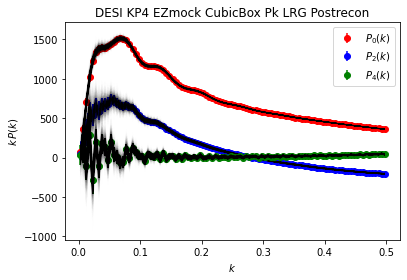

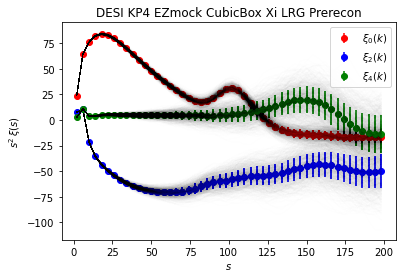

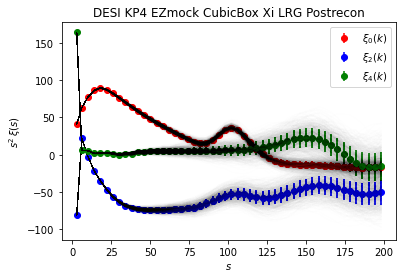

In [17]:
# Loop over tracers
path_abacus = "/global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/AbacusSummit/CubicBox/LRG"
path_ezmock = "/global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/EZmock/CubicBox/LRG"
    
# Power Spectrum
pre_file = path_ezmock + "/Pk/jmena/nmesh_512/dk0.005/"                            # 1000 Prerecon EZmock measurements
post_file = path_ezmock + "/Pk/Post/forero/fiducial_settings/dk0.005/z0.800/"      # 1000 Postrecon EZmock measurements
pre_cov_file = path_ezmock + "/Pk/jmena/nmesh_512/dk0.005/cov.txt"                 # Prerecon EZmock covariance
post_cov_file = path_ezmock + "/Pk/Post/forero/fiducial_settings/dk0.005/z0.800/"  # Postrecon EZmock covariance
name = f"DESI KP4 EZmock CubicBox Pk LRG"
data = collect_pk_data(pre_file, post_file, pre_cov_file, post_cov_file, None, z, "", "", name, preformat="jmf", postformat="dfs", precovformat="jmf", postcovformat="dfs")
plot_pk(data) # Plot the data to check things

# Correlation Function
pre_file = path_ezmock + "/Xi/csaulder/"                                   # 1000 EZmock measurements
post_file = path_ezmock + "/Xi/Post/forero/fiducial_settings/z0.800/"      # 1000 Postrecon EZmock measurements
pre_cov_file = path_ezmock + "/Xi/jmena/cov.txt"                           # Prerecon EZmock covariance
post_cov_file = path_ezmock + "/Xi/Post/forero/fiducial_settings/z0.800/"  # Postrecon EZmock covariance
name = f"DESI KP4 EZmock CubicBox Xi LRG"
data = collect_xi_data(pre_file, post_file, pre_cov_file, post_cov_file, z, "", "", name, preformat="cs", postformat="dfs", precovformat="jmf", postcovformat="dfs")
plot_xi(data) # Plot the data to check things

# Abacus CutSky Mock

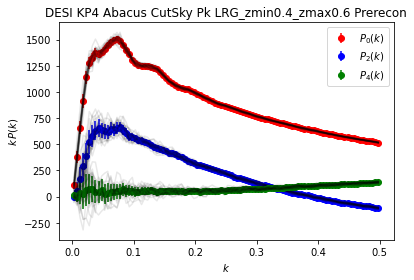

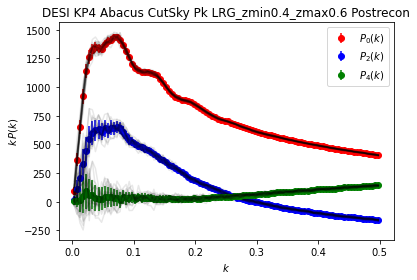

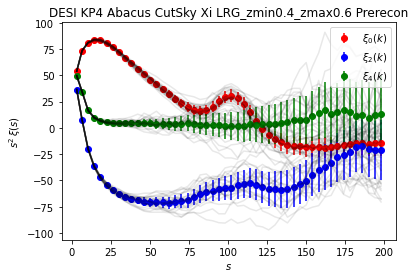

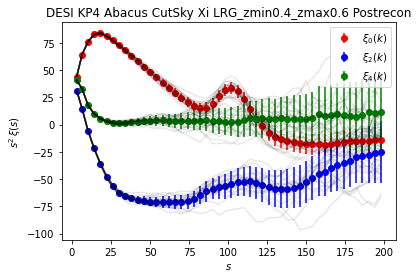

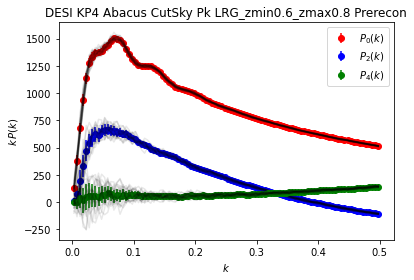

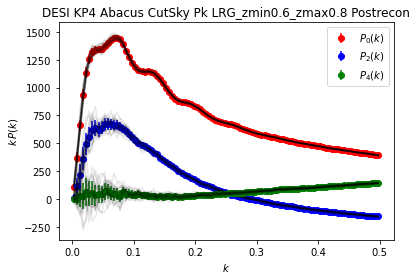

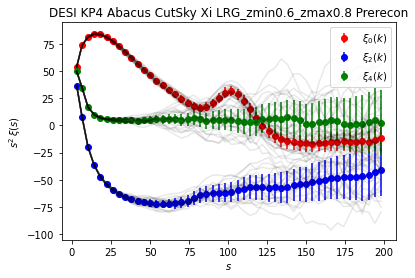

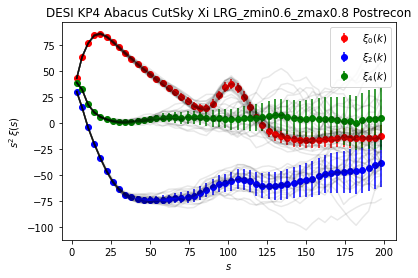

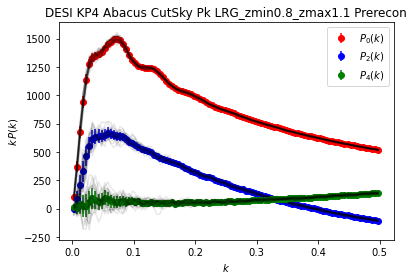

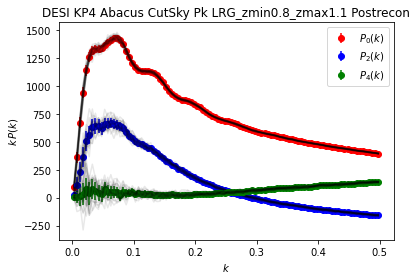

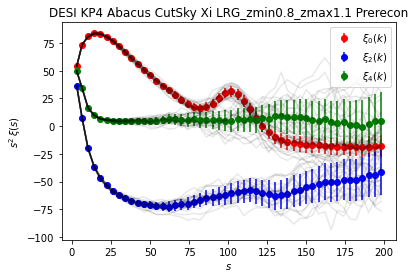

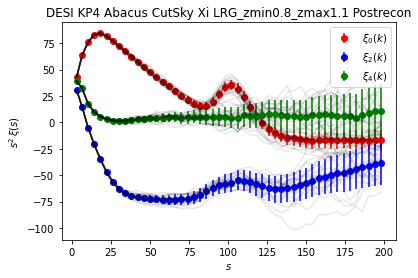

In [26]:
# Loop over tracers and redshift bins
path_abacus = "/global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/AbacusSummit/CutSky/LRG"
path_ezmock = "/global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/EZmock/CutSky/LRG"

# Dictionary containing zmin, zmax and zeff for the tracers
reds = {"LRG": [["0.4", "0.6", 0.5], ["0.6", "0.8", 0.7], ["0.8", "1.1", 0.95]]}

for i, (zmin, zmax, zeff) in enumerate(reds["LRG"]):

    # Power Spectrum
    prezname = "_zmin" + zmin + "_zmax" + zmax
    postzname = "_zmin" + zmin + "_zmax" + zmax
    pre_file = path_abacus + "/Pk/Pre/jmena/nmesh_1024/dk0.005/"       # 25 Prerecon Abacus measurements
    post_file = path_abacus + "/Pk/Post/jmena/nmesh_1024/dk0.005/"     # 25 Postrecon Abacus measurements
    pre_cov_file = path_ezmock + "/Pk/jmena/nmesh_1024/dk0.005/cov" + prezname + ".txt"    # Prerecon EZmock covariance
    post_cov_file = path_ezmock + "/Pk/jmena/nmesh_1024/dk0.005/cov" + postzname + ".txt"  # Prerecon EZmock covariance. TO BE UPDATED!!!!
    winfile = path_abacus + f"/Pk/Pre/jmena/nmesh_1024/windows/window_combined" + prezname
    name = f"DESI KP4 Abacus CutSky Pk LRG" + prezname
    data = collect_pk_data(pre_file, post_file, pre_cov_file, post_cov_file, winfile, zeff, prezname, postzname, name, preformat="jmf", postformat="jmf", precovformat="jmf", postcovformat="jmf")
    plot_pk(data) # Plot the data to check things

    # Correlation Function
    prezname = "_zmin" + zmin + "_zmax" + zmax
    postzname = "_zmin" + zmin + "_zmax" + zmax
    pre_file = path_abacus + "/Xi/Pre/jmena/"    # 25 Prerecon Abacus measurements
    post_file = path_abacus + "/Xi/Post/jmena/"  # 25 Postrecon Abacus measurements
    pre_cov_file = path_abacus + f"/Xi/Pre/csaulder/cov/{zmin[2]}{zmax[2]}_cov.dat"   # Prerecon EZmock covariance.
    post_cov_file = path_abacus + f"/Xi/Pre/csaulder/cov/{zmin[2]}{zmax[2]}_cov.dat"  # Prerecon EZmock covariance. TO BE UPDATED!!!!
    name = f"DESI KP4 Abacus CutSky Xi LRG" + prezname
    data = collect_xi_data(pre_file, post_file, pre_cov_file, post_cov_file, zeff, prezname, prezname, name, preformat="jmf", postformat="jmf", precovformat="cs", postcovformat="cs")
    plot_xi(data) # Plot the data to check things